# Homework 5

Implement a Kalman Filter to estimate the position and orientation of a vehicle from a GPS and an IMU. 
GPS provides global position information but can have accuracy issues due to signal obstructions and multipath errors.
IMU provides high-frequency acceleration and angular velocity measurements but suffers from drift over time. 
The idea is to fuse the data from these sensors and improve the accuracy and reliability of pose estimation for navigation applications.

The Data was collected from the NUANCE autonomous car and stored in a rosbag: https://drive.google.com/file/d/13NTbaSxY7uYbRrld7iVXB27czxcrRTL9/view?usp=drive_link 

We will use "/gps/fix" and "/imu/imu_uncompensated"

In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geo_transforms
from scipy import integrate

# b = bagreader('/home/meuli/src/eece7150/HW5/2023-10-19-14-14-38-filtered.bag')

# # get the list of topics
# print(b.topic_table)

# data_gps = b.message_by_topic('/gps/fix')
# data_imu = b.message_by_topic('/imu/imu_uncompensated')

data_gps = "2023-10-19-14-14-38-filtered/gps-fix.csv"
data_imu = "2023-10-19-14-14-38-filtered/imu-imu_uncompensated.csv"


First GPS Data: <br>
1697739552.3366451 sec, idx=2737 <br><br>
Last GPS Data: <br>
1697742219.9365995 sec, idx=29349

In [2]:
# Save GPS Data to Variables
gps_time = pd.read_csv(data_gps, index_col=0)
gps_lat = pd.read_csv(data_gps, index_col=7)
gps_lon = pd.read_csv(data_gps, index_col=8)

gps_data = np.array([gps_lon.index[:], gps_lat.index[:]])
origin = gps_data[:,2737]  # set the initial position to the origin
gt_trajectory_xyz = geo_transforms.lla_to_enu(gps_data, origin)

gps_x_all, gps_y_all, _ = gt_trajectory_xyz
gps_x = gps_x_all[np.logical_not(np.isnan(gps_x_all))]
gps_y = gps_y_all[np.logical_not(np.isnan(gps_y_all))]
gps_t = gps_time.index[np.logical_not(np.isnan(gps_x_all))]

In [3]:
# Save IMU Data to Variables
imu_time = pd.read_csv(data_imu, index_col=0)
ang_vel_x = pd.read_csv(data_imu, index_col=18)
ang_vel_y = pd.read_csv(data_imu, index_col=19)
ang_vel_z = pd.read_csv(data_imu, index_col=20)
lin_accel_x = pd.read_csv(data_imu, index_col=30)
lin_accel_y = pd.read_csv(data_imu, index_col=31)
lin_accel_z = pd.read_csv(data_imu, index_col=32)

imu_yr = ang_vel_z.index[54719:588367]
imu_a_all = lin_accel_x.index[:]
imu_a = lin_accel_x.index[54719:588367]
imu_t = imu_time.index[54719:588367]

# Kalman Filter Implementation
Code up the Kalman Filter to compute pose estimates using Python.
Define and write up the equations for your process and measurement models, their covariances, and parameters in the Jupyter Notebook.
Define and report the initial conditions, as well. Develop functions for prediction and correction steps and estimate the state iteratively.

Implement a kalman filter to estimate 2D (x, y, theta) pose of the vehicle by fusing GPS and IMU measurements. Use constant-velocity model for IMU or include acceleration component.

Ignore computer accelerometer and gyroscope biases. Estimate them initially by averaging the readings at rest and subtracting them from your readings to unbias the measurements. Assume constant biases.

The process model, measurement model, and covariance update equations must be programmed independently. 

In [4]:
print(len(imu_a_all)/5000)

123.2644


11 -0.14895179416788884
-0.2069127075019512
0.16060776032894158
0.13247684982613483
0.37445880219638206
0.8346442523943429
0.19520035069753972
0.04569411737695239
0.22334077642977787
0.19687613486998437
0.18384077602491383
13 -0.20591189555432932
0.09976904524353326
0.130547572810747
0.2767808257297129
0.050713210736671725
0.09474553895284457
0.49556399220499475
-0.18473839200685552
0.29977534021561897
0.3849314179422159
0.16664098280779843
-0.04667653220629526
0.07842549571508135
59 -0.06401290587690012
0.012751117354035547
-0.03839432588451574
-0.13084553743962662
0.1750231836857865
0.3055584317424059
-0.009846475318076644
0.04934960635281941
-0.0760656718975264
-0.09012239546155847
-0.409184618166781
0.08228353186326597
-0.2245191860046201
0.2056938799023483
-0.45870322118429113
0.11953489553882149
0.09477649813884534
0.1656082967531529
0.25081926293551143
0.07644841592040644
0.10140171514774315
0.36891773659442
0.5248869264709309
-0.03909312097650247
-0.38623984342225776
1.04659569

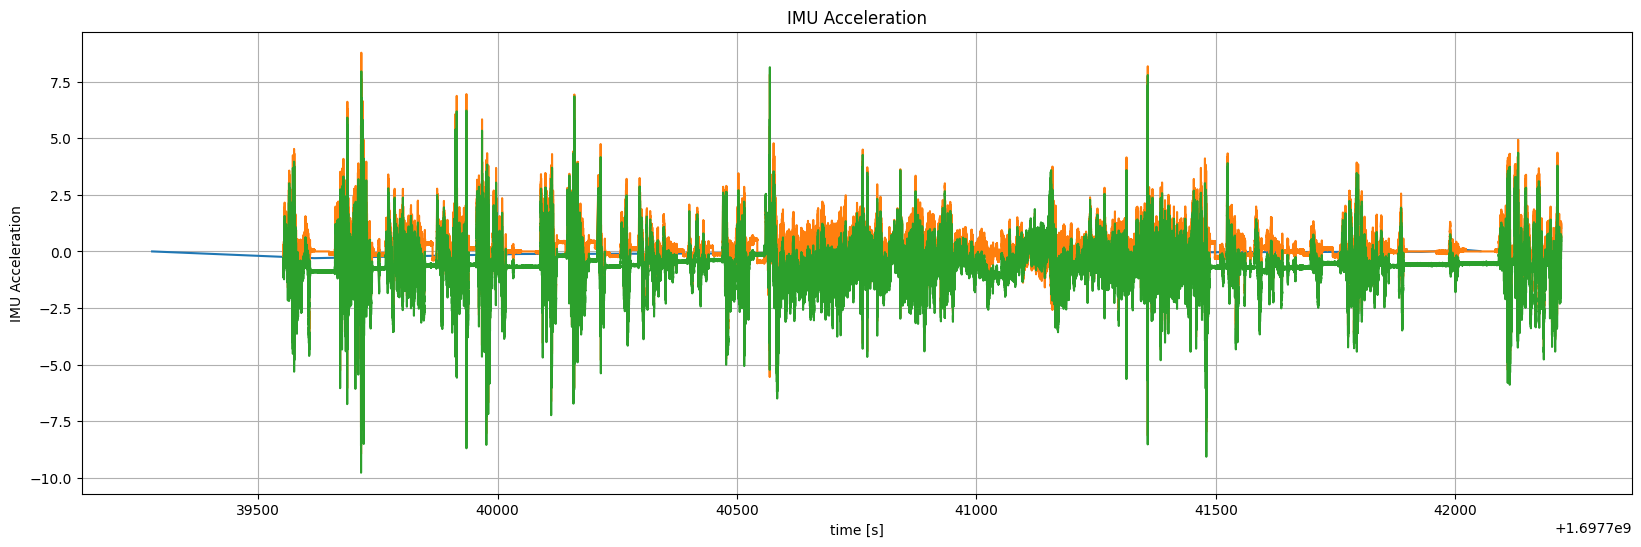

In [5]:
num_iters = 100
imu_a_adjusted = imu_a_all - np.mean(imu_a_all)
imu_a_all1 = list(imu_a_adjusted)
samples_per_iter = int(len(imu_a_all1)/num_iters)

not_zero_iter = 0
start_iter = 0

a_filt = [0]
t_filt = [imu_time.index[0]]

for i in range(num_iters):

    if (all(np.abs(imu_a_all1[ele] - imu_a_all1[start_iter]) < 0.3 for ele in range(start_iter,start_iter+samples_per_iter))):
        a_filt.append(imu_a_all1[start_iter])
        t_filt.append(imu_time.index[start_iter])
        
        imu_a_all1[start_iter:start_iter+samples_per_iter] = [0 for ii in range(start_iter,start_iter+samples_per_iter)]
        imu_a_all1[start_iter - not_zero_iter * samples_per_iter : start_iter] = [imu_a_all1[ii] - (a_filt[-1]+a_filt[-2])/2 for ii in range(start_iter - not_zero_iter * samples_per_iter, start_iter)]
        print(not_zero_iter, (a_filt[-1]+a_filt[-2])/2)

        if (not_zero_iter > 1):
            for i in range(1,not_zero_iter):
                start_idx = start_iter - i * samples_per_iter
                end_idx = start_iter - (i-1) * samples_per_iter

                the_avg = np.average(imu_a_all1[start_idx : end_idx])
                print(the_avg)
                imu_a_all1[start_idx : end_idx] = [imu_a_all1[i] - the_avg for i in range(start_idx, end_idx)]


        # if (not_zero_iter > 5):
           
        start_iter += samples_per_iter
        not_zero_iter = 0
    else:
        start_iter += samples_per_iter
        not_zero_iter += 1

fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t_filt, a_filt)
ax.plot(imu_t, imu_a_all1[54719:588367])
ax.plot(imu_t, imu_a_all[54719:588367])
ax.set_xlabel('time [s]')
ax.set_ylabel('IMU Acceleration')
ax.set_title('IMU Acceleration')
ax.grid()


In [6]:
# Perform IMU Dead Reckoning
theta = 0  # Initial orientation
time0 = imu_t[0]

imu_a_adjusted = imu_a_all - np.mean(imu_a_all[66472:75778])
imu_a_1 = imu_a_adjusted[54719:588367]

imu_v = integrate.cumtrapz(imu_a_all1, imu_time.index[:])

num_iters = 50
samples_per_iter = int(len(imu_v)/num_iters)
start_iter = 0

for i in range(1,num_iters):
    end_iter = start_iter + samples_per_iter

    imu_v_min = min(imu_v[start_iter : end_iter])
    imu_v[start_iter : end_iter] = [imu_v[ii] - imu_v_min for ii in range(start_iter, end_iter)]

    start_iter += samples_per_iter


In [7]:
imu_p = integrate.cumtrapz(imu_v, imu_time.index[1:])
imu_v = imu_v[54719:588367]
imu_p = imu_p[54719:588367]

# Necessary????
ang_vel = imu_yr - np.mean(imu_yr)

yaw_angle = integrate.cumtrapz(ang_vel, imu_t)

px = []
py = []

for i in range(1, len(imu_t)-1):
    dt = imu_t[i] - time0
    time0 = imu_t[i]

    px.append(-imu_v[i] * np.cos(yaw_angle[i]))
    py.append(imu_v[i] * np.sin(yaw_angle[i]))

imu_pE = integrate.cumtrapz(px, imu_t[2:])
imu_pN = integrate.cumtrapz(py, imu_t[2:])

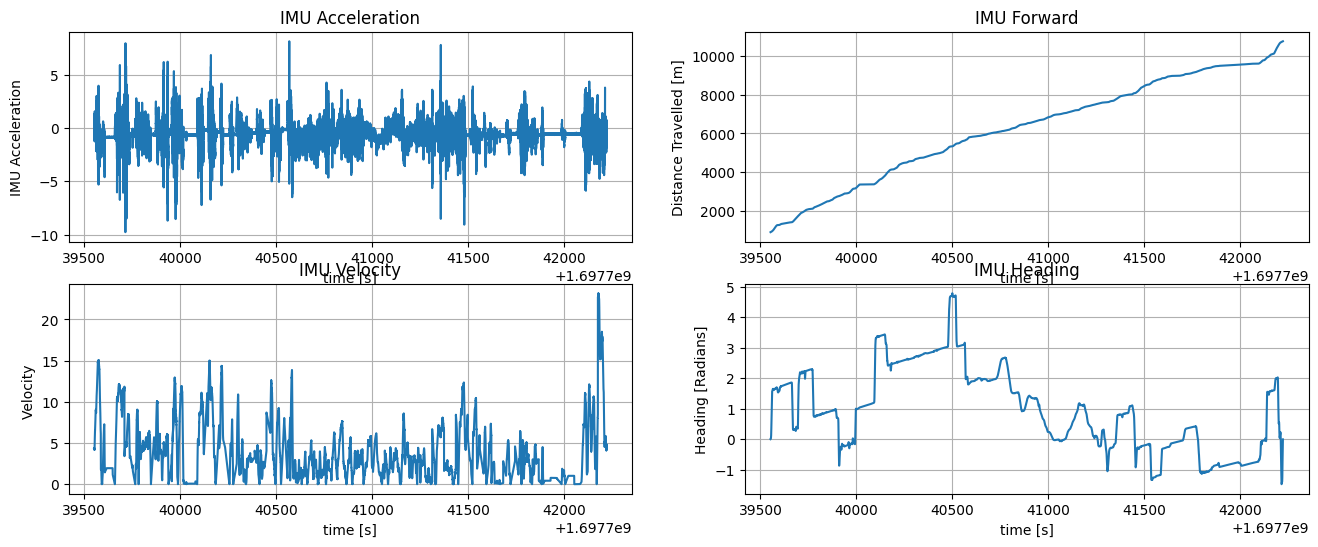

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16, 6))
ax[0,0].plot(imu_t, imu_a)
ax[0,0].set_xlabel('time [s]')
ax[0,0].set_ylabel('IMU Acceleration')
ax[0,0].set_title('IMU Acceleration')
ax[0,0].grid()
ax[1,0].plot(imu_t, imu_v)
ax[1,0].set_xlabel('time [s]')
ax[1,0].set_ylabel('Velocity ')
ax[1,0].set_title('IMU Velocity')
ax[1,0].grid()
ax[0,1].plot(imu_t, imu_p)
ax[0,1].set_xlabel('time [s]')
ax[0,1].set_ylabel('Distance Travelled [m]')
ax[0,1].set_title('IMU Forward')
ax[0,1].grid()
ax[1,1].plot(imu_t[1:], yaw_angle)
ax[1,1].set_xlabel('time [s]')
ax[1,1].set_ylabel('Heading [Radians]')
ax[1,1].set_title('IMU Heading')
ax[1,1].grid()

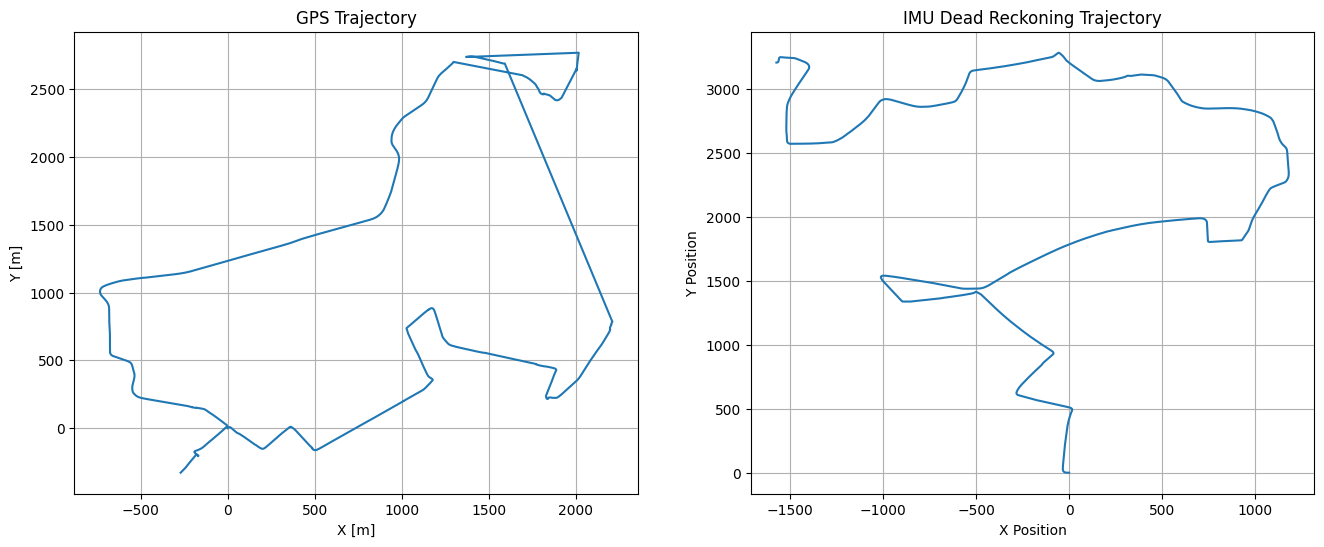

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(gps_x, gps_y)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].set_title('GPS Trajectory')
ax[0].grid()

# Plot the dead reckoning trajectory
ax[1].plot(imu_pE, imu_pN)
ax[1].set_xlabel('X Position')
ax[1].set_ylabel('Y Position')
ax[1].set_title('IMU Dead Reckoning Trajectory')
ax[1].grid()

## Apply Kalman filter!

Let's apply Kalman filter to the GPS/IMU sequence to estimate vehicle 2d pose [x, y, theta].

Be aware that the ground-truth data is used only for the evaluation. i.e., only noised GPS/IMU sequence is given to the filter.

### Prepare initial estimate and its error covariance

Suppose initial 2d position [x, y] estimation are initialized with the first GPS observation.

Since our vehicle has no sensor to measure yaw angle, yaw estimation is initialized randomly and its variance is initialized with some large value (e.g. pi).

In [10]:
# Noise Def
xy_obs_noise_std = 5.0  # standard deviation of observation noise of x and y in meter
yaw_rate_noise_std = 0.02 # standard deviation of yaw rate in rad/s
forward_velocity_noise_std = 0.3 # standard deviation of forward velocity in m/s

In [11]:
# initial state x_0

initial_yaw_std = np.pi
initial_yaw = yaw_angle[0] + np.random.normal(0, initial_yaw_std)

x = np.array([
    gps_x[0],
    gps_y[0],
    initial_yaw
])

In [12]:
# covariance for initial state estimation error (Sigma_0)


P = np.array([
    [xy_obs_noise_std ** 2., 0., 0.],
    [0., xy_obs_noise_std ** 2., 0.],
    [0., 0., initial_yaw_std ** 2.]
])

### Prepare measuerment error covariance Q

In [13]:
Q = np.array([
    [xy_obs_noise_std ** 2., 0.],
    [0., xy_obs_noise_std ** 2.]
])

### Prepare state transition noise covariance R

In [14]:
R = np.array([
    [forward_velocity_noise_std ** 2., 0., 0.],
    [0., forward_velocity_noise_std ** 2., 0.],
    [0., 0., yaw_rate_noise_std ** 2.]
])

In [15]:
print(len(gps_y))
print(len(imu_v))

21871
533648


### Kalman filter main routine

In [16]:
def interpolate_gps_data(imu_timestamps, gps_timestamps, gps_data_x, gps_data_y):
    # Interpolate GPS data to match IMU data timestamps
    interpolated_gps_data = []
    for imu_timestamp in imu_timestamps:
        # Find the closest GPS timestamp before the IMU timestamp
        closest_gps_timestamp_index = np.argmin(gps_timestamps <= imu_timestamp)

        # Find the next GPS timestamp after the IMU timestamp
        next_gps_timestamp_index = np.argmin(gps_timestamps > imu_timestamp)

        # Calculate the time difference between the IMU timestamp and the two closest GPS timestamps
        time_difference_before = imu_timestamp - gps_timestamps[closest_gps_timestamp_index]
        time_difference_after = gps_timestamps[next_gps_timestamp_index] - imu_timestamp

        # Calculate the weights for interpolation
        weight_before = time_difference_after / (time_difference_before + time_difference_after)
        weight_after = time_difference_before / (time_difference_before + time_difference_after)

        # Interpolate the GPS data
        interpolated_gps_x = weight_before * gps_data_x[closest_gps_timestamp_index] + weight_after * gps_data_x[next_gps_timestamp_index]
        interpolated_gps_y = weight_before * gps_data_y[closest_gps_timestamp_index] + weight_after * gps_data_y[next_gps_timestamp_index]

        # Append the interpolated GPS datum to the list
        interpolated_gps_data.append((interpolated_gps_x, interpolated_gps_y))

    return interpolated_gps_data

In [17]:
# gps_timestamps = gps_time.index[np.logical_not(np.isnan(gps_x))]

# imu_timestamps = imu_time.index[54719:588367]

# my_gps_data = interpolate_gps_data(imu_time.index[:], gps_time.index[np.logical_not(np.isnan(gps_x))], gps_x[np.logical_not(np.isnan(gps_x))], gps_y[np.logical_not(np.isnan(gps_x))])

In [18]:
my_gps_x = gps_x#[]
my_gps_y = gps_y #[]


# for i in range(len(my_gps_data)):
#     my_gps_x.append(my_gps_data[i][0])
#     my_gps_y.append(my_gps_data[i][1])

In [21]:
from extended_kalman_filter import ExtendedKalmanFilter as EKF
from utils import normalize_angles

N = len(imu_t)  # number of data point

In [22]:
# initialize Kalman filter
kf = EKF(x, P)

# array to store estimated 2d pose [x, y, theta]
mu_x = [x[0],]
mu_y = [x[1],]
mu_theta = [x[2],]

# array to store estimated error variance of 2d pose
var_x = [P[0, 0],]
var_y = [P[1, 1],]
var_theta = [P[2, 2],]

t_last = 0.
gps_idx = 0
t_last = gps_t[gps_idx]

for t_idx in range(1, N-1):
    dt = imu_t[t_idx] - imu_t[t_idx - 1]
    
    # get control input `u = [v, omega] + noise`
    u = np.array([
        imu_v[t_idx],
        ang_vel[t_idx]
    ])
    
    # because velocity and yaw rate are multiplied with `dt` in state transition function,
    # its noise covariance must be multiplied with `dt**2.`
    R_ = R * (dt ** 2.)
    
    # propagate!
    kf.propagate(u, dt, R)
    
    if (imu_t[t_idx] > t_last):
        # get measurement `z = [x, y] + noise`
        z = np.array([
            my_gps_x[gps_idx],
            my_gps_y[gps_idx]
        ])
        
        # update!
        kf.update(z, Q)

        gps_idx += 1

        t_last = gps_t[gps_idx]

    
    
    # save estimated state to analyze later
    mu_x.append(kf.x[0])
    mu_y.append(kf.x[1])
    mu_theta.append(normalize_angles(kf.x[2]))
    
    # save estimated variance to analyze later
    var_x.append(kf.P[0, 0])
    var_y.append(kf.P[1, 1])
    var_theta.append(kf.P[2, 2])
    

mu_x = np.array(mu_x)
mu_y = np.array(mu_y)
mu_theta = np.array(mu_theta)

var_x = np.array(var_x)
var_y = np.array(var_y)
var_theta = np.array(var_theta)

In [23]:
print(my_gps_x)

[-4.12028266e-02 -4.12028236e-02  0.00000000e+00 ... -2.60372327e+02
 -2.66113784e+02 -2.70852578e+02]


## Visualize estimated results

### trajectory

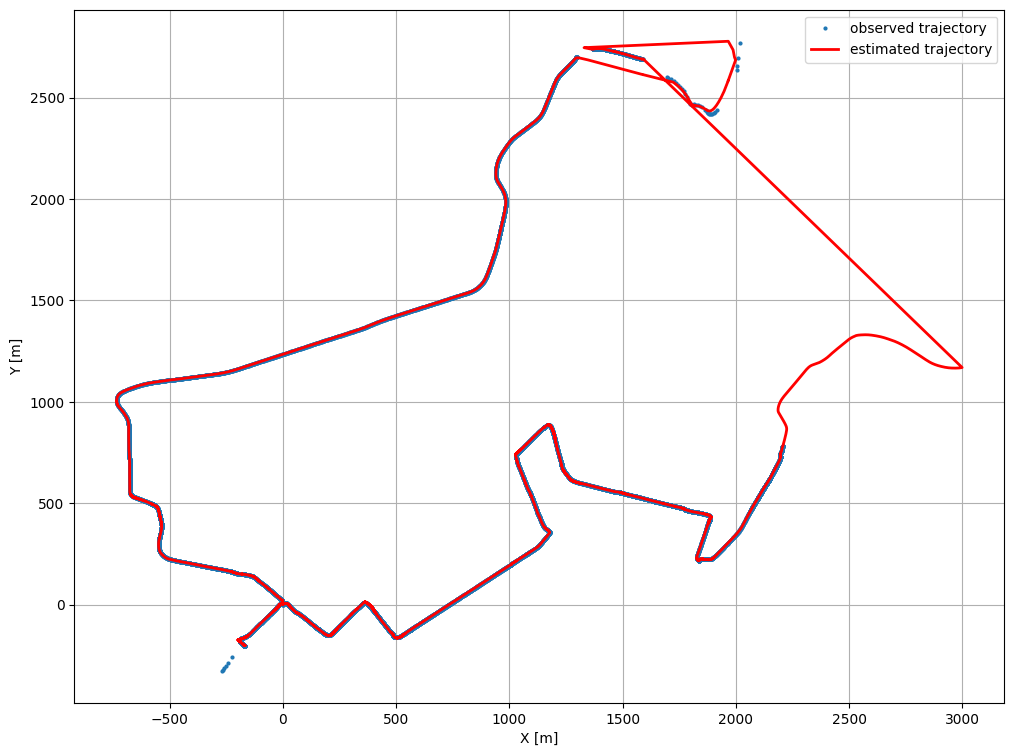

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

# xs, ys, _ = gt_trajectory_xyz
# ax.plot(xs, ys, lw=2, label='ground-truth trajectory')

xs, ys, _ = gt_trajectory_xyz
ax.plot(xs, ys, lw=0, marker='.', markersize=4, alpha=1., label='observed trajectory')

ax.plot(mu_x, mu_y, lw=2, label='estimated trajectory', color='r')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
ax.grid()

# Discussion and Analysis
Plot the raw GPS reading, Deadreckoned IMU estimates and the Kalman filtered state estimates of both the translational and rotational components. 

Reflect on the results and discuss the advantages and limitations of the Kalman filter fusion in improving position estimation.